---
title: Assignment 04
subtitle: https://github.com/met-ad-688/assignment-04-leoliu36.git
author:
  - name: Leo Liu
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: '2025-9-30'
format:
  docx:
    toc: true
    number-sections: true
date-modified: today
date-format: long
execute:
  echo: false
  eval: true
  freeze: auto
---

Feature Engineering and Missing Value Imputation

In [1]:
# DATA LOADING & SETUP
import pandas as pd
import plotly.express as px
import plotly.io as pio
from pyspark.sql import SparkSession
import re
import numpy as np
import plotly.graph_objects as go
from pyspark.sql.functions import col, split, explode, regexp_replace, transform, when, trim, monotonically_increasing_id, pow, length, sum as spark_sum
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

np.random.seed(42)

pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine", "true").option("quote", "\"").option("escape", "\"").csv("../data/lightcast_job_postings.csv")
df.createOrReplaceTempView("job_postings")

# Show Schema and Sample Data
#print("---This is Diagnostic check, No need to print it in the final doc---")
#df.printSchema() # comment this line when rendering the submission
df.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/09 01:18:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/09 01:18:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

# Data Loading & Cleaning 
The dataset contains columns with irrelevant data and missing values, which can negatively impact the performance of our predictive models. To address this, columns containing unnecessary information for our analysis will be removed. We then define the dependent, independent, and categorical variables; columns with over 50% missing values will be dropped. For the remaining columns, only rows with non-null values will be kept for modeling.  

In [2]:
# DATA CLEANING
# Drop columns that are not needed for this analysis 
columns_to_drop = [
  # tracking & other metadata
    "ID", "LAST_UPDATED_DATE", "LAST_UPDATED_TIMESTAMP", "DUPLICATES",
    "SOURCE_TYPES", "SOURCES", "URL", "ACTIVE_URLS", "ACTIVE_SOURCES_INFO", "MODELED_EXPIRED", "MODELED_DURATION", "TITLE_RAW", "ORIGINAL_PAY_PERIOD"
  # outdated NAICS and SOC codes
    "NAICS2", "NAICS2_NAME", "NAICS3", "NAICS3_NAME",
    "NAICS4", "NAICS4_NAME", "NAICS5", "NAICS5_NAME",
    "NAICS6", "NAICS6_NAME", 
    "SOC_2", "SOC_2_NAME", "SOC_3", "SOC_3_NAME",
    "SOC_4", "SOC_4_NAME", "SOC_5", "SOC_5_NAME",
    "SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME",
    "SOC_2021_5", "SOC_2021_5_NAME",
    "NAICS_2022_2", "NAICS_2022_2_NAME", "NAICS_2022_3", "NAICS_2022_3_NAME",
    "NAICS_2022_4", "NAICS_2022_4_NAME", "NAICS_2022_5", "NAICS_2022_5_NAME"
  # Location encodings
    "COUNTY_OUTGOING", "COUNTY_NAME_OUTGOING",
    "COUNTY_INCOMING", "COUNTY_NAME_INCOMING",
    "MSA_OUTGOING", "MSA_NAME_OUTGOING",
    "MSA_INCOMING", "MSA_NAME_INCOMING"
]

# Drop columns 
df = df.drop(*columns_to_drop)

# Show resulting schema
df.printSchema()

root
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- BODY: string (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (nullable = true)
 |-- MIN_EDULEVELS_NAME: string (nullable = true)
 |-- MAX_EDULEVELS: integer (nullable = true)
 |-- MAX_EDULEVELS_NAME: string (nullable = true)
 |-- EMPLOYMENT_TYPE: integer (nullable = true)
 |-- EMPLOYMENT_TYPE_NAME: string (nullable = true)
 |-- MIN_YEARS_EXPERIENCE: integer (nullable = true)
 |-- MAX_YEARS_EXPERIENCE: integer (nullable = true)
 |-- IS_INTERNSHIP: boolean (nullable = true)
 |-- SALARY: integer (nullable = true)
 |-- REMOTE_TYPE: integer (nullable = true)
 |-- REMOTE_TYPE_NAME: string (nul

In [3]:
# Define columns for EDA: 
# dependent variable: SALARY
# indepdendent variable: MIN_YEARS_EXPERIENCE, SALARY_FROM, SALARY_TO, DURATION 
# categorical variables: COMPANY_IS_STAFFING, IS_INTERNSHIP, REMOTE_TYPE_NAME, EMPLOYMENT_TYPE_NAME, MIN_EDULEVELS_NAME, MAX_EDULEVELS_NAME, STATE_NAME

from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

eda_columns = [
    "SALARY",
    "MIN_YEARS_EXPERIENCE", "DURATION",
    "COMPANY_IS_STAFFING", "IS_INTERNSHIP", "REMOTE_TYPE_NAME", "EMPLOYMENT_TYPE_NAME",
    "MIN_EDULEVELS_NAME", "STATE_NAME"
]
df_eda = df.select(eda_columns)
df_eda.show(5, truncate=False)

+------+--------------------+--------+-------------------+-------------+----------------+----------------------+-------------------+----------+
|SALARY|MIN_YEARS_EXPERIENCE|DURATION|COMPANY_IS_STAFFING|IS_INTERNSHIP|REMOTE_TYPE_NAME|EMPLOYMENT_TYPE_NAME  |MIN_EDULEVELS_NAME |STATE_NAME|
+------+--------------------+--------+-------------------+-------------+----------------+----------------------+-------------------+----------+
|NULL  |2                   |6       |false              |false        |[None]          |Full-time (> 32 hours)|Bachelor's degree  |Arkansas  |
|NULL  |3                   |NULL    |true               |false        |Remote          |Full-time (> 32 hours)|No Education Listed|Maine     |
|NULL  |5                   |35      |false              |false        |[None]          |Full-time (> 32 hours)|Bachelor's degree  |Texas     |
|NULL  |3                   |48      |false              |false        |[None]          |Full-time (> 32 hours)|No Education Listed|Ariz

In [4]:
from pyspark.sql.functions import col, split, explode, regexp_replace, transform, when, trim, monotonically_increasing_id, pow, length, sum as spark_sum
import hvplot.pandas

# Visualize the percentage of missing values for each column
df_na = df_eda.select([
    spark_sum(
        when(col(c).isNull() | (length(trim(col(c))) == 0), 1)
    ).alias(c)
    for c in df_eda.columns
])

df_na_pd = df_na.toPandas().T.reset_index()
df_na_pd.columns = ["column", "missing_count"]

total_rows = df.count()
df_na_pd["missing_pct"] = df_na_pd["missing_count"] / total_rows * 100


df_na_pd.sort_values("missing_pct", ascending=False).hvplot.bar(
    x="column",
    y="missing_pct",
    title="Percentage of Missing Values by Column",
    xlabel="Column Name",
    ylabel="Percentage of Missing Values",
    rot=45,
    height=600,
    width=1000
)

:Bars   [column]   (missing_pct)

In [5]:
import pandas as pd
import hvplot.pandas  # make sure this is imported for hvplot support

# Sample a small fraction of the data and convert to Pandas
df_sample = df_eda.sample(fraction=0.05, seed=42).toPandas()

# Create a boolean mask of missing values
missing_mask = df_sample.isnull()

# Melt the mask into long-form format
missing_long = (
    missing_mask.reset_index()
    .melt(id_vars="index", var_name="column", value_name="is_missing")
)

# Convert boolean to int (True → 1, False → 0)
missing_long["is_missing"] = missing_long["is_missing"].astype(int)

# Plot heatmap
missing_long.hvplot.heatmap(
    x="column", y="index", C="is_missing",
    cmap="Reds", colorbar=False,
    width=900, height=700,
    title="Heatmap of Missing Values (Sample)"
).opts(xrotation=45)


:HeatMap   [column,index]   (is_missing)

In [6]:
from pyspark.sql.functions import countDistinct

# Count number of unique values per column
df_eda.select([
    countDistinct(c).alias(c + "_nunique")
    for c in df_eda.columns
]).show(truncate=False)

# Select REMOTE_TYPE_NAME and MIN_EDULEVELS_NAME as the two categorical columns for further inspection
categorical_cols = [
    #"STATE_NAME", 
    "REMOTE_TYPE_NAME", 
    #"EMPLOYMENT_TYPE_NAME",
    "MIN_EDULEVELS_NAME",
    #"COMPANY_IS_STAFFING", "IS_INTERNSHIP"
]

for colname in categorical_cols:
    print(f"\n---- {colname} ----")
    df_eda.select(colname).distinct().show(50, truncate=False)

+--------------+----------------------------+----------------+---------------------------+---------------------+------------------------+----------------------------+--------------------------+------------------+
|SALARY_nunique|MIN_YEARS_EXPERIENCE_nunique|DURATION_nunique|COMPANY_IS_STAFFING_nunique|IS_INTERNSHIP_nunique|REMOTE_TYPE_NAME_nunique|EMPLOYMENT_TYPE_NAME_nunique|MIN_EDULEVELS_NAME_nunique|STATE_NAME_nunique|
+--------------+----------------------------+----------------+---------------------------+---------------------+------------------------+----------------------------+--------------------------+------------------+
|6052          |16                          |60              |2                          |2                    |4                       |3                           |6                         |51                |
+--------------+----------------------------+----------------+---------------------------+---------------------+------------------------+-----------

+----------------+
|REMOTE_TYPE_NAME|
+----------------+
|Remote          |
|[None]          |
|Not Remote      |
|Hybrid Remote   |
|NULL            |
+----------------+


---- MIN_EDULEVELS_NAME ----


+----------------------------+
|MIN_EDULEVELS_NAME          |
+----------------------------+
|Bachelor's degree           |
|Ph.D. or professional degree|
|High school or GED          |
|Master's degree             |
|No Education Listed         |
|Associate degree            |
|NULL                        |
+----------------------------+



In [7]:
# For REMOTE_TYPE_NAME replace Remote with Remote, [None] with undefined, Not Remote with On Premise, Hybrid Remote with Hybrid, and Null with On Premise 

from pyspark.sql.functions import col, when

df_eda = df_eda.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "On Premise")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)

# create a temporary SQL view if using Spark SQL queries later
df_eda.createOrReplaceTempView("df_eda")
print(f"\n---- Distinct Values in REMOTE_TYPE_NAME ----")
df_eda.select("REMOTE_TYPE_NAME").distinct().show(10, truncate=False)


---- Distinct Values in REMOTE_TYPE_NAME ----


+----------------+
|REMOTE_TYPE_NAME|
+----------------+
|Remote          |
|On Premise      |
|Hybrid          |
+----------------+



In [8]:
# For MIN_EDULEVELS_NAME, replace null with No Education Listed

from pyspark.sql.functions import col, when

df_eda = df_eda.withColumn(
    "MIN_EDULEVELS_NAME",
    when(col("MIN_EDULEVELS_NAME").isNull(), "No Education Listed")
    .otherwise(col("MIN_EDULEVELS_NAME"))
)

# create a temporary SQL view if using Spark SQL queries later
df_eda.createOrReplaceTempView("df_eda")
print(f"\n---- Distinct Values in MIN_EDULEVELS_NAME ----")
df_eda.select("MIN_EDULEVELS_NAME").distinct().show(10, truncate=False)


---- Distinct Values in MIN_EDULEVELS_NAME ----


+----------------------------+
|MIN_EDULEVELS_NAME          |
+----------------------------+
|Bachelor's degree           |
|Ph.D. or professional degree|
|High school or GED          |
|Master's degree             |
|No Education Listed         |
|Associate degree            |
+----------------------------+



In [9]:
# Calculate median for DURATION
median_DURATION = df_eda.approxQuantile("DURATION", [0.5], 0.01)[0]

# Check for nulls in DURATION and impute with median

df_eda = df_eda.withColumn(
    "DURATION",
    when(col("DURATION").isNull(), median_DURATION)
    .otherwise(col("DURATION"))
)

# Feature Engineering 
For this section, we will define key features for modeling based on relevance to the target variable (SALARY). Categorical variables related to experience, duration, remote status, and employment type were chosen as features to be encoded using StringIndexer and OneHotEncoder and assembled into a vector in preparation for modeling. 

In [10]:
# FEATURE ENGINEERING

from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Drop rows with NA Values 
df_eda = df_eda.dropna(subset=[
    "SALARY",
    "MIN_YEARS_EXPERIENCE", "DURATION",
    "COMPANY_IS_STAFFING", "IS_INTERNSHIP", "REMOTE_TYPE_NAME", "EMPLOYMENT_TYPE_NAME",
    "MIN_EDULEVELS_NAME", "STATE_NAME"
])

# Define categorical columns to encode
categorical_cols = [
    "MIN_EDULEVELS_NAME", 
    "REMOTE_TYPE_NAME"
]

# Index and One-Hot Encode
indexers = [
    StringIndexer(
        inputCol=col, 
        outputCol=f"{col}_idx", 
        handleInvalid="skip"
    ) for col in categorical_cols
]

encoders = [
    OneHotEncoder(
        inputCol=f"{col}_idx", 
        outputCol=f"{col}_vec"
    ) for col in categorical_cols
]

In [12]:
# Assemble base features (for GLR and Random Forest)
assembler = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "DURATION",
        "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

# Build pipeline and transform df_eda
pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df_eda).transform(df_eda)

# Create squared term for Polynomial Regression
data = data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"), 2))

# Assemble polynomial features
assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "MIN_YEARS_EXPERIENCE_SQ", "DURATION",
        "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_poly"
)

# Transform with polynomial features
data = assembler_poly.transform(data)

# Show sample of features and label
data.select("SALARY", "features", "features_poly").show(5, truncate=False)

+------+----------------------------------+-------------------------------------------+
|SALARY|features                          |features_poly                              |
+------+----------------------------------+-------------------------------------------+
|92962 |(11,[0,1,4,9],[2.0,18.0,1.0,1.0]) |(12,[0,1,2,5,10],[2.0,4.0,18.0,1.0,1.0])   |
|107645|(11,[0,1,7,9],[10.0,18.0,1.0,1.0])|(12,[0,1,2,8,10],[10.0,100.0,18.0,1.0,1.0])|
|192800|(11,[0,1,4,9],[6.0,55.0,1.0,1.0]) |(12,[0,1,2,5,10],[6.0,36.0,55.0,1.0,1.0])  |
|125900|(11,[0,1,6,9],[12.0,18.0,1.0,1.0])|(12,[0,1,2,7,10],[12.0,144.0,18.0,1.0,1.0])|
|170000|(11,[0,1,5,9],[6.0,18.0,1.0,1.0]) |(12,[0,1,2,6,10],[6.0,36.0,18.0,1.0,1.0])  |
+------+----------------------------------+-------------------------------------------+
only showing top 5 rows


# Train/Test Split
The dataset containing vectorized features will be split into 80% for Training and 20% for Testing to ensure that the model evaluation is unbiased. This split will be applied throughout the various models (GLR, Polynomial GLR, and Random Forest) to allow us to compare the results.

In [13]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Confirm the split sizes
print(f"Training rows: {train_data.count()}")
print(f"Testing rows: {test_data.count()}")

Training rows: 18966


Testing rows: 4731


# GLR Model Summary
The GLR model yielded an intercept of $118,078 with several of the features demonstrating statistical significance. Among those features, the most influential and positive coefficient is MIN_YEARS_EXPERIENCE (+$7441.28, p=0.0008), indicating that higher salaries roles often require more years of experience. On the otherhand, the most influential and statistically significant negative coefficient is lower education levels, specifically 'Associated Degree' (-$65370, p>0001). It's also worth noting that IS_INTERNSHIP and COMPANY_IS_STAFFING are both statistically significant negative coefficients, suggesting that internships and staffing firms tend to offer lower salaries. 

In [14]:
# GLR
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from IPython.display import HTML
import pandas as pd

feature_names = assembler.getInputCols()

# Define Generalized Linear Regression model
glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",     # continuous outcome, normal distribution
    link="identity",       # standard linear regression
    maxIter=10,            # number of iterations 
    regParam=0.3           # regularization parameter (lambda)
)

# Fit model on training data
glr_model = glr.fit(train_data)

# evaluate RMSE on test data 
glr_predictions = glr_model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol="SALARY",
    predictionCol="prediction",
    metricName="rmse"
)
glr_rmse = evaluator.evaluate(glr_predictions)
print(f"\nGLR RMSE on Test Data: {glr_rmse:.2f}")

# Get model summary
summary = glr_model.summary

# Coefficients and Intercept
# Intercept represents the predicted salary when all input features = 0.
# Coefficient represents the estimated change in salary per one-unit change in respective feature (while everything else is constant).
print("Intercept: {:.4f}".format(glr_model.intercept))
print("Coefficients:")
for i, coef in enumerate(glr_model.coefficients):
    print(f" Feature {i+1}: {coef:.4f}")

# Regression Summary
#Smaller coefficient standard error means more reliable estimates
print("\n--- Regression Summary: ---")
print("Coefficient Standard Errors:",[f"{val:.4f}" for val in summary.coefficientStandardErrors])

# T-values measures how many standard errors the coefficient is away from 0; >2 is statistically significant
# P-values measure the probability that the coefficient is actually 0; <0.05 is statistically significant
print("T Values:", [f"{val:.4f}" for val in summary.tValues])
print("P Values:", [f"{val:.4f}" for val in summary.pValues])

# Dispersion - variance of residuals
print(f"\nDispersion: {summary.dispersion:.4f}")
# Null Deviance - how much “unexplained” variation exists with no predictors.
print(f"Null Deviance: {summary.nullDeviance:.4f}")
# Residual DF Null - how many data points are left after accounting for 1 parameter (the mean)
print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
# Residual Deviance - Variation not explained by the model. Smaller deviance = better fit.
print(f"Deviance: {summary.deviance:.4f}")
print(f"Residual DF: {summary.residualDegreeOfFreedom}")
# AIC - metric for model quality that balances goodness of fit and model complexity. Lower AIC = better model
print(f"AIC: {summary.aic:.4f}")

# Presentation
# get feature names from GLR summary (Java backend)
feature_names = summary._call_java("featureNames")
features = ["Intercept"] + feature_names

# build all stats lists (include intercept)
coefs = [glr_model.intercept] + list(glr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

# sanity check
print("--- This is a diagnostic check ---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))

# create summary DataFrame
coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t-Value": [f"{v:.4f}" if v is not None else None for v in tvals],
    "p-Value": [f"{v:.4f}" if v is not None else None for v in pvals]
})

# export to CSV
coef_table.to_csv("output/glr_summary.csv", index=False)

# display in notebook
HTML(coef_table.to_html(index=False))


GLR RMSE on Test Data: 35634.53
Intercept: 118077.7423
Coefficients:
 Feature 1: 7441.2826
 Feature 2: -73.8928
 Feature 3: -3048.7849
 Feature 4: -3147.0268
 Feature 5: -31047.8353
 Feature 6: -27419.8882
 Feature 7: -65370.0192
 Feature 8: -65034.1694
 Feature 9: 5845.2032
 Feature 10: -1291.2053
 Feature 11: -1726.5664

--- Regression Summary: ---


Coefficient Standard Errors: ['80.9467', '21.9980', '4744.7230', '876.2733', '7975.2611', '7997.4419', '8037.8830', '8030.3752', '8100.2761', '1473.5361', '1535.6262', '8125.5372']
T Values: ['91.9281', '-3.3591', '-0.6426', '-3.5914', '-3.8930', '-3.4286', '-8.1327', '-8.0985', '0.7216', '-0.8763', '-1.1243', '14.5317']
P Values: ['0.0000', '0.0008', '0.5205', '0.0003', '0.0001', '0.0006', '0.0000', '0.0000', '0.4705', '0.3809', '0.2609', '0.0000']

Dispersion: 1210670973.7533


Null Deviance: 35794690345776.1094
Residual DF Null: 18965
Deviance: 22947057636519.6797
Residual DF: 18954


AIC: 450500.4524
--- This is a diagnostic check ---
Length of features: 12
Length of coefs: 12
Length of se: 12
Length of tvals: 12
Length of pvals: 12


Feature,Estimate,Std Error,t-Value,p-Value
Intercept,118077.7423,80.9467,91.9281,0.0000
MIN_YEARS_EXPERIENCE,7441.2826,21.9980,-3.3591,0.0008
DURATION,-73.8928,4744.7230,-0.6426,0.5205
IS_INTERNSHIP,-3048.7849,876.2733,-3.5914,0.0003
COMPANY_IS_STAFFING,-3147.0268,7975.2611,-3.8930,0.0001
MIN_EDULEVELS_NAME_vec_Bachelor's degree,-31047.8353,7997.4419,-3.4286,0.0006
MIN_EDULEVELS_NAME_vec_No Education Listed,-27419.8882,8037.8830,-8.1327,0.0000
MIN_EDULEVELS_NAME_vec_Associate degree,-65370.0192,8030.3752,-8.0985,0.0000
MIN_EDULEVELS_NAME_vec_High school or GED,-65034.1694,8100.2761,0.7216,0.4705
MIN_EDULEVELS_NAME_vec_Master's degree,5845.2032,1473.5361,-0.8763,0.3809


# Polynomial GLR Model Summary
The Polynomial GLR model yielded an intercept of $110,905, slightly lower than the linear GLR model. MIN_YEARS_EXPERIENCE remained the most influential positive predictor (+$11948.86, p < 0.0001), while MIN_YEARS_EXPERIENCE_SQ was statistically significant but negative (−$343.47, p = 0.0004). This indicates that salary growth sees a plateau with increasing years of experience. As with the linear GLR model, the statistically significant negative predictors were lower education levels and roles offered by staffing firms. Notably, IS_INTERNSHIP was a statistically significant positive predictor in this model, highlighting the unpredictable effect that the added polynomial effect may have on the model's behavior.



In [15]:
# Poly GLR
from pyspark.ml.regression import GeneralizedLinearRegression
from IPython.display import HTML
import pandas as pd

# Define GLR model for polynomial features
poly_glr = GeneralizedLinearRegression(
    featuresCol="features_poly",
    labelCol="SALARY",
    family="gaussian",
    link="identity",
    maxIter=10,
    regParam=0.3
)

# Fit model using training data
poly_glr_model = poly_glr.fit(train_data)

# Evaluate RMSE for poly test data
poly_predictions = poly_glr_model.transform(test_data)
poly_rmse = evaluator.evaluate(poly_predictions)
print(f"Polynomial GLR RMSE: {poly_rmse:.2f}")

# Get model summary
poly_summary = poly_glr_model.summary

# Coefficients and Intercept
print("Intercept: {:.4f}".format(poly_glr_model.intercept))
print("Coefficients:")
for i, coef in enumerate(poly_glr_model.coefficients):
    print(f" Feature {i+1}: {coef:.4f}")

# Regression Summary
print("\n--- Regression Summary: ---")
print("Coefficient Standard Errors:",[f"{val:.4f}" for val in poly_summary.coefficientStandardErrors])

# T-values measures how many standard errors the coefficient is away from 0; >2 is statistically significant
# P-values measure the probability that the coefficient is actually 0; <0.05 is statistically significant
print("T Values:", [f"{val:.4f}" for val in poly_summary.tValues])
print("P Values:", [f"{val:.4f}" for val in poly_summary.pValues])

# Dispersion - variance of residuals
print(f"\nDispersion: {poly_summary.dispersion:.4f}")
# Null Deviance - how much “unexplained” variation exists with no predictors.
print(f"Null Deviance: {poly_summary.nullDeviance:.4f}")
# Residual DF Null - how many data points are left after accounting for 1 parameter (the mean)
print(f"Residual DF Null: {poly_summary.residualDegreeOfFreedomNull}")
# Residual Deviance - Variation not explained by the model. Smaller deviance = better fit.
print(f"Deviance: {poly_summary.deviance:.4f}")
print(f"Residual DF: {poly_summary.residualDegreeOfFreedom}")
# AIC - metric for model quality that balances goodness of fit and model complexity. Lower AIC = better model
print(f"AIC: {poly_summary.aic:.4f}")

# Presentation
# get feature names from poly GLR summary (Java backend)
feature_names = poly_summary._call_java("featureNames")
features = ["Intercept"] + feature_names

# build all stats lists (include intercept)
coefs = [poly_glr_model.intercept] + list(poly_glr_model.coefficients)
se = list(poly_summary.coefficientStandardErrors)
tvals = list(poly_summary.tValues)
pvals = list(poly_summary.pValues)

# sanity check
print("--- This is a diagnostic check ---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))

# create summary DataFrame
poly_coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t-Value": [f"{v:.4f}" if v is not None else None for v in tvals],
    "p-Value": [f"{v:.4f}" if v is not None else None for v in pvals]
})

# export to CSV
poly_coef_table.to_csv("output/glr_summary.csv", index=False)

# display in notebook
HTML(poly_coef_table.to_html(index=False))


Polynomial GLR RMSE: 35513.74
Intercept: 110905.3631
Coefficients:
 Feature 1: 11948.8614
 Feature 2: -343.4661
 Feature 3: -76.8774
 Feature 4: 626.9998
 Feature 5: -3415.3221
 Feature 6: -34843.3820
 Feature 7: -31037.9782
 Feature 8: -63953.6989
 Feature 9: -68645.3489
 Feature 10: 3549.0876
 Feature 11: -1355.3830
 Feature 12: -1408.9606

--- Regression Summary: ---


Coefficient Standard Errors: ['277.6073', '20.2478', '21.8341', '4714.1994', '869.8596', '7918.7412', '7940.4594', '7978.1695', '7973.1235', '8040.7983', '1462.5140', '1524.2495', '8075.8072']
T Values: ['43.0423', '-16.9632', '-3.5210', '0.1330', '-3.9263', '-4.4001', '-3.9088', '-8.0161', '-8.6096', '0.4414', '-0.9267', '-0.9244', '13.7330']
P Values: ['0.0000', '0.0000', '0.0004', '0.8942', '0.0001', '0.0000', '0.0001', '0.0000', '0.0000', '0.6589', '0.3541', '0.3553', '0.0000']

Dispersion: 1192618999.9018


Null Deviance: 35794690345776.1094
Residual DF Null: 18965
Deviance: 22603707905139.5312
Residual DF: 18953


AIC: 450216.5255
--- This is a diagnostic check ---
Length of features: 13
Length of coefs: 13
Length of se: 13
Length of tvals: 13
Length of pvals: 13


Feature,Estimate,Std Error,t-Value,p-Value
Intercept,110905.3631,277.6073,43.0423,0.0000
MIN_YEARS_EXPERIENCE,11948.8614,20.2478,-16.9632,0.0000
MIN_YEARS_EXPERIENCE_SQ,-343.4661,21.8341,-3.5210,0.0004
DURATION,-76.8774,4714.1994,0.1330,0.8942
IS_INTERNSHIP,626.9998,869.8596,-3.9263,0.0001
COMPANY_IS_STAFFING,-3415.3221,7918.7412,-4.4001,0.0000
MIN_EDULEVELS_NAME_vec_Bachelor's degree,-34843.3820,7940.4594,-3.9088,0.0001
MIN_EDULEVELS_NAME_vec_No Education Listed,-31037.9782,7978.1695,-8.0161,0.0000
MIN_EDULEVELS_NAME_vec_Associate degree,-63953.6989,7973.1235,-8.6096,0.0000
MIN_EDULEVELS_NAME_vec_High school or GED,-68645.3489,8040.7983,0.4414,0.6589


# Random Forest Model
As shown in the feature importance plot, MIN_YEARS_EXPERIENCE stands out as the most influential predictor, making up for over 70% of the model’s predictive power. This confirms the finding across all models that years of experience is a critical driver of salary. Following that, education-related features — "High School or GED" and "Master’s" — also contributed meaningfully. Features such as "Duration", "On-Premise", "Remote", and "Staffing Agency" showed minimal impact in the RF model’s decision-making, which helps us better understand the importance of the output from GLR-based models.

In [16]:
# Random Forest
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Define the model
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="SALARY",
    numTrees=200,
    maxDepth=6,
    seed=42
)

# Train model on training data
rf_model = rf.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate RMSE on RF test data
rf_rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse:.2f}")

# R-squared
evaluator.setMetricName("r2")
r2 = evaluator.evaluate(rf_predictions)
print(f"R-squared: {r2:.4f}")


25/10/09 01:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1118.7 KiB
25/10/09 01:21:11 WARN DAGScheduler: Broadcasting large task binary with size 1907.1 KiB


Random Forest RMSE: 34478.66


R-squared: 0.3884


In [17]:
# Feature Importance Plot
from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import numpy as np
import pandas as pd

# Reconstruct and expand feature names 
# refit pipeline to get OneHotEncoderModels
fitted_pipeline = pipeline.fit(df_eda)

# extract OneHotEncoder stages 
ohe_feature_names = []
for i, col in enumerate(categorical_cols):
    encoder_model = fitted_pipeline.stages[len(indexers) + i]  # each encoder is separate
    num_categories = encoder_model.categorySizes[0] - 1        # dropLast=True
    ohe_feature_names += [f"{col}_vec_{j}" for j in range(num_categories)]

# combine full list in correct order
feature_names = [
    "MIN_YEARS_EXPERIENCE", "DURATION",
    "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
] + ohe_feature_names

# extract feature importances from RF model
importances = rf_model.featureImportances.toArray()
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Select top 10
#feat_imp_df = feat_imp_df.sort_values("Importance", ascending=False)
#top10_df = feat_imp_df.head(10)

/tmp/ipykernel_1714/1329682924.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




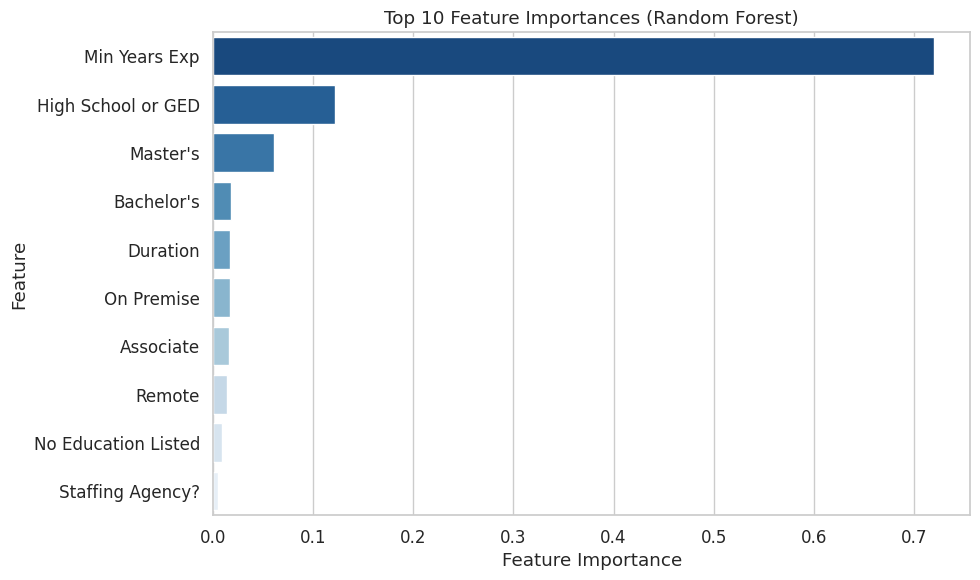

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# mapping categories for MIN_EDULEVELS_NAME
edu_map = {
    "MIN_EDULEVELS_NAME_vec_0": "Bachelor's",
    "MIN_EDULEVELS_NAME_vec_1": "No Education Listed",
    "MIN_EDULEVELS_NAME_vec_2": "Associate",
    "MIN_EDULEVELS_NAME_vec_3": "High School or GED",
    "MIN_EDULEVELS_NAME_vec_4": "Master's"
}

# mapping categories for REMOTE_TYPE_NAME
remote_map = {
    "REMOTE_TYPE_NAME_vec_0": "On Premise",
    "REMOTE_TYPE_NAME_vec_1": "Remote"
}

# combine all mappings
feature_label_map = {
    **edu_map,
    **remote_map,
    "MIN_YEARS_EXPERIENCE": "Min Years Exp",
    "DURATION": "Duration",
    "IS_INTERNSHIP": "Internship?",
    "COMPANY_IS_STAFFING": "Staffing Agency?"
}

# Apply mapping
feat_imp_df["Feature_Clean"] = feat_imp_df["Feature"].map(feature_label_map).fillna(feat_imp_df["Feature"])

top10_df = feat_imp_df.sort_values("Importance", ascending=False).head(10)

# Create output folder
os.makedirs("output", exist_ok=True)

# Create bar plot
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature_Clean", 
    data=top10_df, 
    palette="Blues_r"
)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()

plt.savefig("output/rf_feature_importance.png", dpi=300)
plt.show()

# Model Comparison
To evaluate the predictive performance of the GLR, Polynomial GLR, and Random Forest models, the following metrics were used for comparison:

- RMSE: measurement of the average prediction error in $.

- AIC: assessment of model fit while penalizing complexity; lower is better.

- BIC: similar to AIC but applies a heavier penalty for model complexity.

In [ ]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator

# Predict on test data
glr_preds = glr_model.transform(test_data)
poly_preds = poly_glr_model.transform(test_data)
rf_preds = rf_model.transform(test_data)

# Define evaluator for RMSE
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")

glr_rmse = evaluator.evaluate(glr_preds)
poly_rmse = evaluator.evaluate(poly_preds)
rf_rmse = evaluator.evaluate(rf_preds)

# print("GLR RMSE:", round(glr_rmse, 2))
# print("Polynomial GLR RMSE:", round(poly_rmse, 2))
# print("Random Forest RMSE:", round(rf_rmse, 2))

# Define AIC from model summary
glr_aic = glr_model.summary.aic
poly_aic = poly_glr_model.summary.aic


# Calculate BIC
def compute_bic(summary, k):
    n = summary.numInstances
    dev = summary.deviance
    disp = summary.dispersion
    logL = -0.5 * (n * math.log(2 * math.pi) + n * math.log(disp) + dev / disp)
    return k * math.log(n) - 2 * logL

glr_bic = compute_bic(glr_model.summary, len(glr_model.coefficients))
poly_bic = compute_bic(poly_glr_model.summary, len(poly_glr_model.coefficients))


# Define comparison table and export to .csv
comparison_df = pd.DataFrame({
    "Model": ["GLR", "Polynomial GLR", "Random Forest"],
    "RMSE": [round(glr_rmse, 2), round(poly_rmse, 2), round(rf_rmse, 2)],
    "AIC": [round(glr_aic, 2), round(poly_aic, 2), None],
    "BIC": [round(glr_bic, 2), round(poly_bic, 2), None]
})

display(comparison_df)


Model Comparison Summary:


,Model,RMSE,AIC,BIC
0,GLR,35634.53,450500.45,450582.81
1,Polynomial GLR,35513.74,450216.53,450306.73
2,Random Forest,34478.66,NaN,NaN


Based on RMSE, the RF model outperformed the GLR models in terms of predictive accuracy. However, since AIC and BIC values are not applicable to RF, this model cannot be relied on solely to interpret model complexity. While Poly GLR outperformed the standard GLR in both RMSE and AIC/BIC, the margin of improvement is not substaitial enough to justify the added compleixty of the polynomial term. A hybrid approach of the RF and standard GLR model will ensure accuracy for salary predictions and better interpretibility into the key drivers of salary.  

# Actual vs. Predicted Salary: Model Comparison

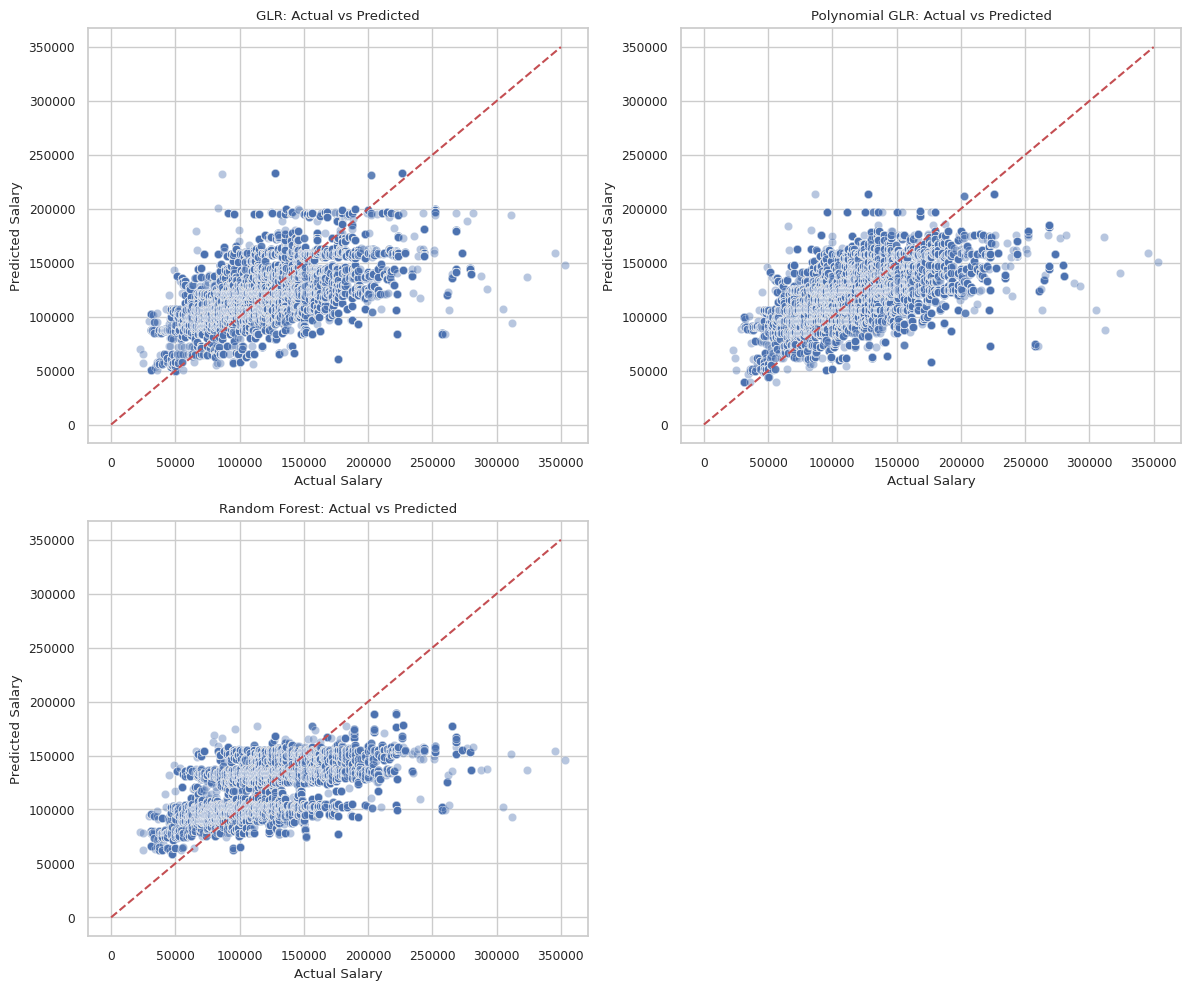

In [24]:
# Keep the SALARY column in all 3 prediction DataFrames
glr_pd = glr_preds.select("SALARY", "prediction").withColumnRenamed("prediction", "GLR_Pred")
poly_pd = poly_preds.select("SALARY", "prediction").withColumnRenamed("prediction", "Poly_Pred")
rf_pd = rf_preds.select("SALARY", "prediction").withColumnRenamed("prediction", "RF_Pred")

# Now join using the shared column SALARY
combined_preds = glr_pd \
    .join(poly_pd, on="SALARY") \
    .join(rf_pd, on="SALARY")

# Convert to pandas
combined_df = combined_preds.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=0.8)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot for GLR
sns.scatterplot(data=combined_df, x="SALARY", y="GLR_Pred", ax=axes[0, 0], alpha=0.4)
axes[0, 0].plot([0, 350000], [0, 350000], 'r--')
axes[0, 0].set_title("GLR: Actual vs Predicted")
axes[0, 0].set_xlabel("Actual Salary")
axes[0, 0].set_ylabel("Predicted Salary")


# Plot for Polynomial GLR
sns.scatterplot(data=combined_df, x="SALARY", y="Poly_Pred", ax=axes[0, 1], alpha=0.4)
axes[0, 1].plot([0, 350000], [0, 350000], 'r--')
axes[0, 1].set_title("Polynomial GLR: Actual vs Predicted")
axes[0, 1].set_xlabel("Actual Salary")
axes[0, 1].set_ylabel("Predicted Salary")

# Plot for Random Forest
sns.scatterplot(data=combined_df, x="SALARY", y="RF_Pred", ax=axes[1, 0], alpha=0.4)
axes[1, 0].plot([0, 350000], [0, 350000], 'r--')
axes[1, 0].set_title("Random Forest: Actual vs Predicted")
axes[1, 0].set_xlabel("Actual Salary")
axes[1, 0].set_ylabel("Predicted Salary")

# Hide bottom-right subplot
axes[1, 1].axis("off")

plt.tight_layout()
plt.savefig("output/model_comparison_plots.png", dpi=300)
plt.show()

Key Observations:
- GLR:
The GLR model predictions generally follow the trend of actual salaries but with greater dispersion at higher salary levels. The model is underpredicting high salaries and overpredicting some lower salaries, demonstrating the limitation of linear assumptions.

- Polynomial GLR:
The polynomial model shows a tighter dispersion at mid range salaries compared to GLR; but similarly, it is undepredicting and overpredicting salaries at the higher and lower extremes, respectively. 

- Random Forest:
The Random Forest model demonstrates the tightest clustering around the diagonal, which suggests the best predictive accuracy among the models. However, it also underpredicts higher salary levels (>$200,000), which is expected since the random forest model tends to average results. 